In [9]:
%matplotlib inline

import allel
import numpy as np
import pandas as pd
import zarr
from pathlib import Path
import scipy
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

%run tools.py

### GAARDIAN - Ghana - G12

In [10]:
sample_set = "1244-VO-GH-YAWSON-VMF00149"
chroms = ['2L', '2R', '3L', '3R', 'X']

snps = {}
pos = {}

for chrom in chroms:
    
    snps[chrom], pos[chrom], metadata = load_arrays_and_metadata("../resources", sample_set, chrom)
    
metadata['location2'] = metadata['location'].str.split(".").str.get(0)

How many do we have from each species?

In [11]:
metadata.species_gambiae_coluzzii.value_counts()

coluzzii    422
gambiae      63
Name: species_gambiae_coluzzii, dtype: int64

How many samples do we have from each village??

In [12]:
metadata.location2.value_counts().head(10)

Domenase        57
Annorkrom       49
New Edubiase    42
Pokukrom        37
Odumto          34
Koniyaw         32
Nkotumso        30
Kokotro         28
Prisintease     24
Kente           24
Name: location2, dtype: int64

## G12

In [13]:
def cluster_G12(gnalt, cut_height=0.1, metric='euclidean', g=2):
    """
    Hierarchically clusters genotypes and calculates G12 statistic. 
    """
    # cluster the genotypes in the window
    dist = scipy.spatial.distance.pdist(gnalt.T, metric=metric)
    if metric in {'hamming', 'jaccard'}:
        # convert distance to number of SNPs, easier to interpret
        dist *= gnalt.shape[0]

    Z = scipy.cluster.hierarchy.linkage(dist, method='single')
    cut = scipy.cluster.hierarchy.cut_tree(Z, height=cut_height)[:, 0]
    cluster_sizes = np.bincount(cut)
    clusters = [np.nonzero(cut == i)[0] for i in range(cut.max() + 1)]
    
    # get freq of clusters and sort by largest freq
    freqs = cluster_sizes/gnalt.shape[1]
    freqs = np.sort(freqs)[::-1]
    
    # calculate g12
    g12 = np.sum(freqs[:g])**2 + np.sum(freqs[g:]**2)
    
    return(g12)

def garuds_G12(gnalt, pos, cut_height=None, metric='euclidean', window_size=1000, step_size=500, cluster=False):
    
    """
    Calculates G12, stores windows in .tsv and plots
    """
        
    # Do we want to cluster the Multi-locus genotypes (MLGs), or just group MLGs if they are identical
    if cluster:
        g12 = allel.moving_statistic(gnalt, cluster_G12, size=window_size, step=step_size, metric=metric, cut_height=cut_height)
    else:
        g12,_,_,_ = allel.moving_garud_h(gnalt, size=window_size, step=step_size)

    midpoint = allel.moving_statistic(pos, np.median, size=window_size, step=step_size)
    
    return(g12, midpoint)


### Run G12

In [16]:
for chrom in chroms:
    
    # Count alleles per site
    ac = snps[chrom].count_alleles()
    # Get boolean array for biallelic or not
    bial_bool = ac.is_biallelic()
    # Filter arrays to biallelic only
    geno = snps[chrom].compress(bial_bool, axis=0)
    positions = pos[chrom][bial_bool]

    # have edited .species_gambiae_coluzzii column to contain 'arabiensis' instead of NA 
    for sp in metadata.species_gambiae_coluzzii.unique():

        # filter to species 
        nmeta3 = metadata[metadata.species_gambiae_coluzzii == sp]
        flt = np.array(nmeta3.index)
        # filter to correct loc, year, species individuals
        gt_cohort = geno.take(flt, axis=1)

        log(f"--------- Running G12 on {sp} Chromosome {chrom} ----------")
        log("filter to biallelic segregating sites")
        ac_cohort = gt_cohort.count_alleles(max_allele=3).compute()
        # N.B., if going to use to_n_alt later, need to make sure sites are 
        # biallelic and one of the alleles is the reference allele
        ref_ac = ac_cohort[:, 0]
        loc_sites = ac_cohort.is_biallelic() & (ref_ac > 0)
        gt_seg = da.compress(loc_sites, gt_cohort, axis=0)
        pos_seg = da.compress(loc_sites, pos, axis=0)

        log("compute input data for G12")
        pos_seg = pos_seg.compute()
        gn_seg = allel.GenotypeDaskArray(gt_seg).to_n_alt().compute()

        # calculate G12 and plot figs 
        g12, midpoint = garuds_G12(gnalt=gn_seg, 
                                   pos=pos_seg, 
                                   cut_height=6,
                                   metric='euclidean',
                                   window_size=1200,
                                   step_size=600, 
                                   cluster=True)
        
        saveAndPlot(statName="G12", 
                    values=g12, 
                    midpoints=midpoint,
                    prefix="../results/selection/G12", 
                    species=sp,
                    chrom=chrom,
                    ylim=0.5)

--------- Running G12 on gambiae Chromosome 2L ----------
filter to biallelic segregating sites


/home/sanj/apps/anaconda3/envs/pysanj/lib/python3.7/site-packages/dask/array/core.py:2756: UserWarning: Passing an object to dask.array.from_array which is already a Dask collection. This can lead to unexpected behavior.
  "Passing an object to dask.array.from_array which is already a "


AxisError: Axis 0 is out of bounds for array of dimension 0

### Coluzzii only with altered cut height

In [31]:
colbool = metadata.species_gambiae_coluzzii == 'coluzzii'
colmeta = metadata[colbool]

--------- Running G12 on coluzzii Chromosome 2L ----------
There are 6465187 segregating sites and 422 individuals


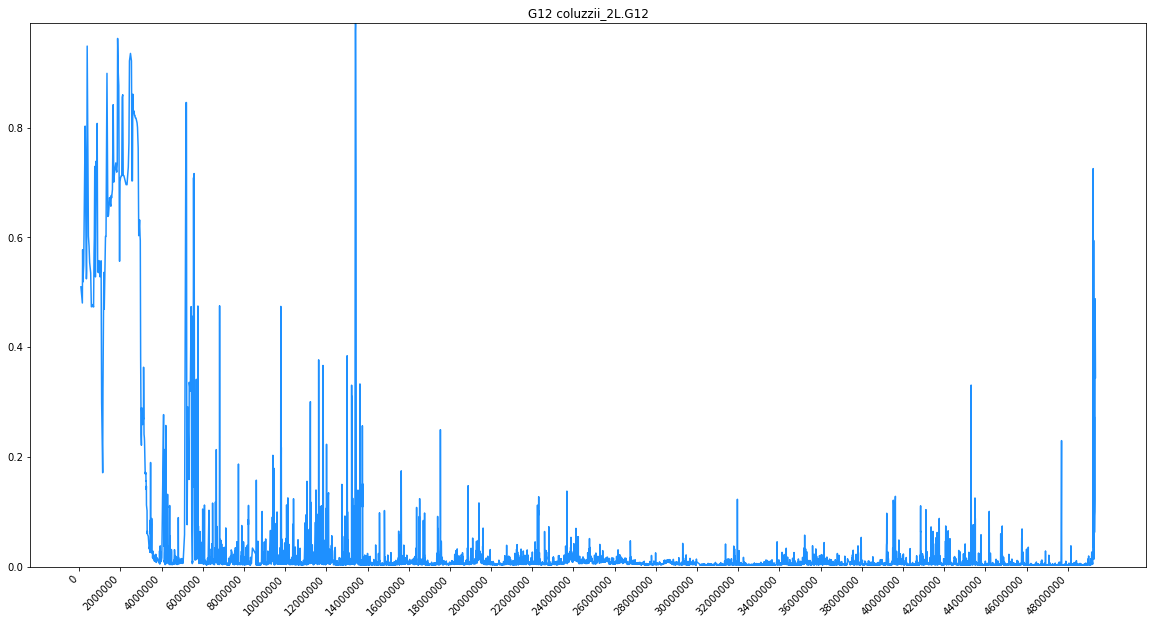

--------- Running G12 on coluzzii Chromosome 2R ----------
There are 7032346 segregating sites and 422 individuals


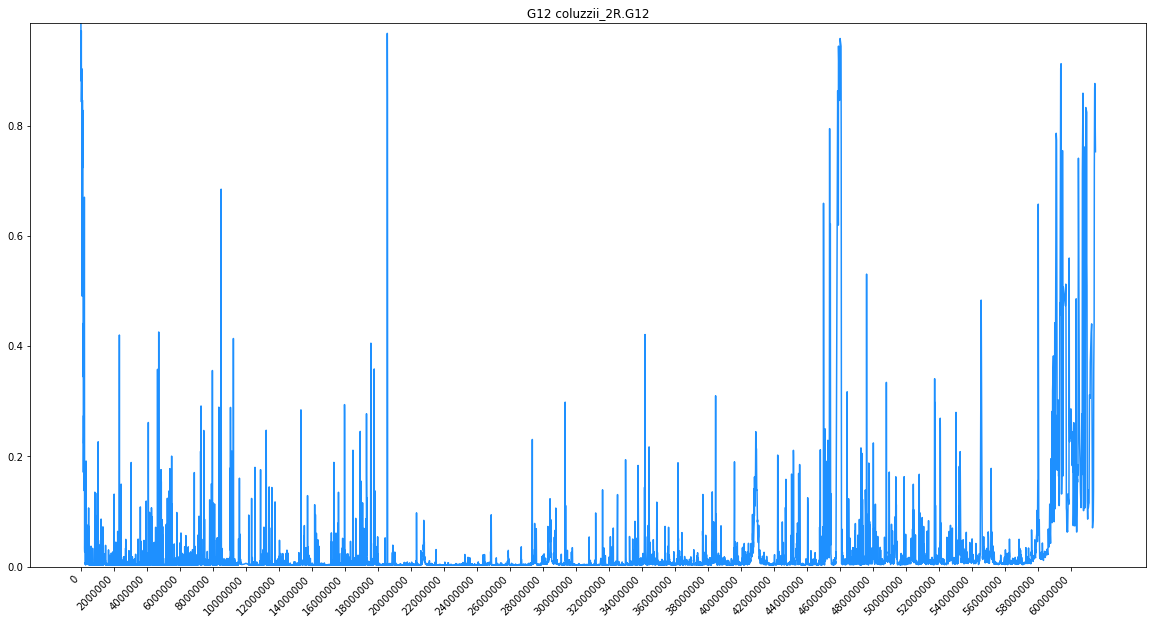

--------- Running G12 on coluzzii Chromosome 3L ----------
There are 5749134 segregating sites and 422 individuals


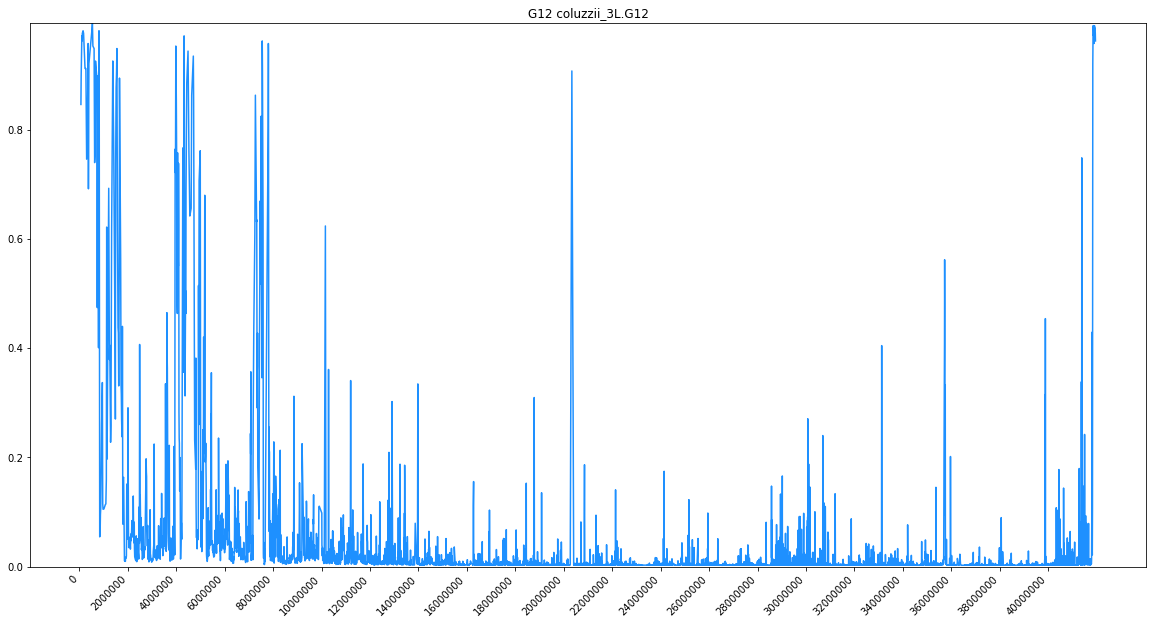

--------- Running G12 on coluzzii Chromosome 3R ----------
There are 7959589 segregating sites and 422 individuals


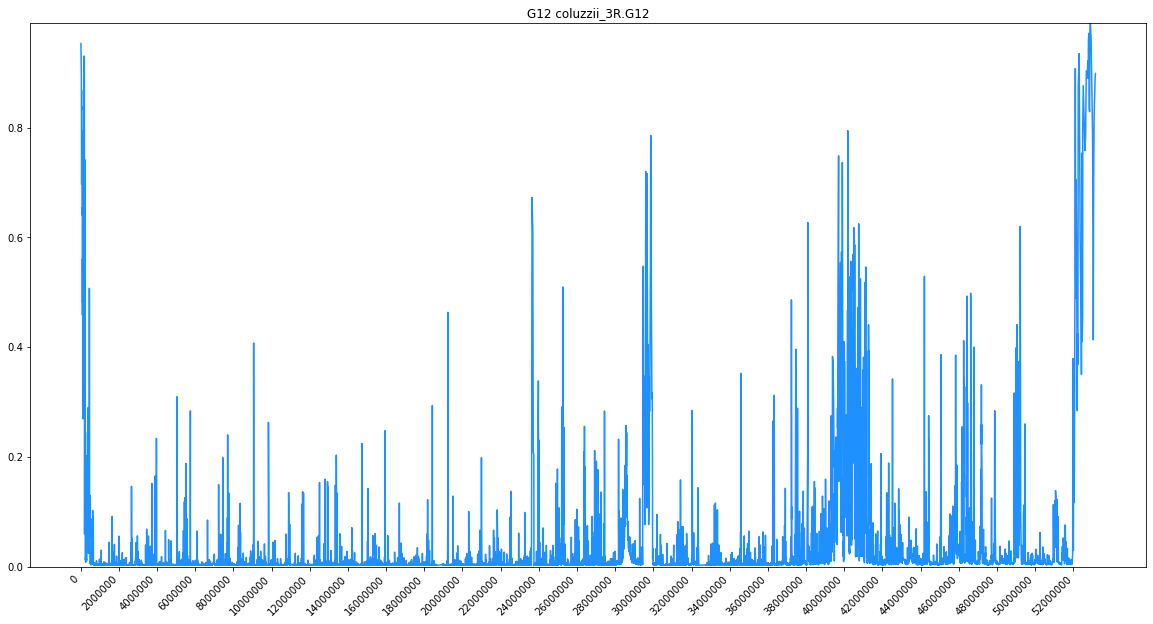

--------- Running G12 on coluzzii Chromosome X ----------
There are 2629996 segregating sites and 422 individuals


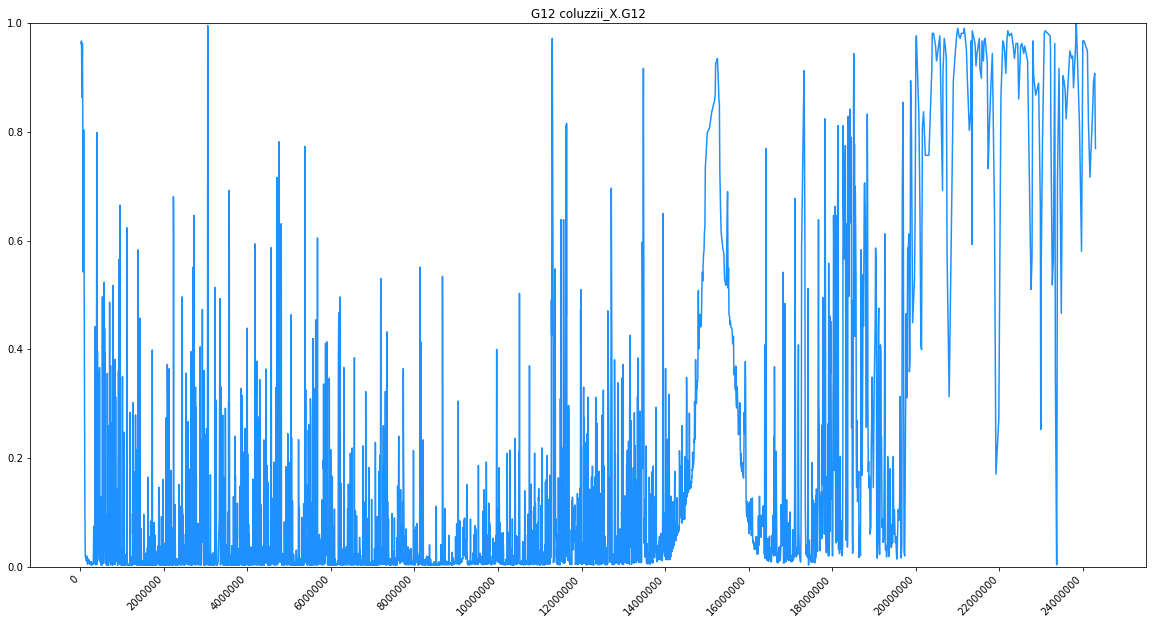

In [33]:
for chrom in chroms:
    
    # Count alleles per site
    ac = snps[chrom].compress(colbool, axis=1).count_alleles()
    # Get boolean array for biallelic or not
    bial_bool = ac.is_biallelic()
    # Filter arrays to biallelic only
    geno = snps[chrom].compress(bial_bool, axis=0)
    positions = pos[chrom][bial_bool]

            # have edited .species_gambiae_coluzzii column to contain 'arabiensis' instead of NA 
    for sp in colmeta.species_gambiae_coluzzii.unique():

        #filter to species 
        nmeta3 = metadata[metadata.species_gambiae_coluzzii == sp]
        flt = np.array(nmeta3.index)
        # filter to correct loc, year, species individuals
        gn = geno.take(flt, axis=1)

        print(f"--------- Running G12 on {sp} Chromosome {chrom} ----------")

        # filter to segregating sites only as the phase 3 arrays contain every SNP on the chromosome
        seg = gn.count_alleles().is_segregating()
        gn = gn.compress(seg, axis=0)
        pos1 = positions[seg]

        print(f"There are {gn.shape[0]} segregating sites and {gn.shape[1]} individuals")

        # convert to 0,1,2 genotypes
        gn_alt = gn.to_n_alt().compute()

        # calculate G12 and plot figs 
        garuds_G12(gnalt=gn_alt, pos=pos1, cut_height=5,
                   save=False, 
                   prefix='../results',
                   name=f"{sp}_{chrom}.G12", 
                   metric='euclidean',
                  window_size=1000,
                  step_size=500, cluster=True, species=sp)